# Deep Crossentropy Algorithm
## A form of Approximate RL
### Tested on CartPole-v0

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

state vector dim = 4
n_actions = 2


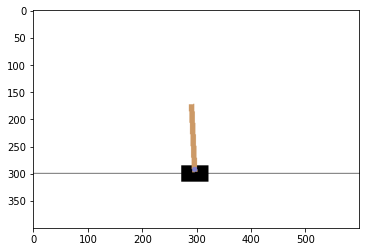

In [1]:
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

### Here, the policy will be approximated using a....
## Neural Network!

## Algorithm Details - 

#### 1. Create a neural network agent

In [3]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

#### 2. Run the game with the current policy


In [5]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to get action probabilities at state s
        probs = np.reshape(agent.predict_proba([s]), (2,))
        
        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities to pick an action
        a = np.random.choice(range(n_actions), p = probs)
        
        new_s, r, done, info = env.step(a)
        
#         ax.clear()
#         ax.imshow(env.render('rgb_array'))
#         fig.canvas.draw()
        
        # record sessions
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

#### 3. After running on given policy, select the best(or elite) sessions

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Given the batch of states, actions and rewards,
    Select the sessions for which rewards >= threshold
    These are the elite sessions and will be used to update policy
    """
    #First find the reward threshold
    reward_threshold = np.percentile(rewards_batch, percentile)
    #Get all the elite sessions
    elite_sessions = np.where(rewards_batch >= reward_threshold)[0]
    #Go through all elite sessions and append the states and actions into lists
    elite_states = []
    elite_actions = []
    
    for sess in elite_sessions:
        for state in states_batch[sess]:
            elite_states.append(state)
        for action in actions_batch[sess]:
            elite_actions.append(action)

    return elite_states, elite_actions

In [8]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

# Training loop
Generate sessions, select N best and fit to those

mean reward = 469.210, threshold=575.600


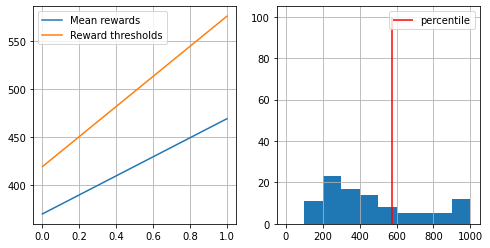

This is more than enough! Stopping


In [10]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #1.2. Generate sessions using current policy
    sessions = [generate_session(env, agent) for session in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    #3. Get elite sessions
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    #4. Update policy by performing partial fit on elite sessions
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 400:
        print("This is more than enough! Stopping")
        break
    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [11]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

In [12]:
# Show video. This may not work in some setups.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices